## Introduction
**Chapter 9. 기계 독해(Machine Reading Comprehension) Task** 강의의 **한국어 기계 독해 실습 (1) 데이터 수집 및 전처리** 강의입니다.

이번 실습에서는 (1) 기계 독해 작업을 수행하기 위한 한국어 기계 독해 데이터셋(KorQuAD)를 수집하고, (2) 수집한 데이터셋을 전처리하는 과정을 진행해보겠습니다.

이번 강의에서는 문맥(context)과 질문(question)으로 구성된 KorQuAD 데이터셋의 입/출력을 만들기 위한 여러가지 자연어 전처리 기술을 소개하며,

특히, 문맥(context)과 질문(question)을 입력으로 받고, 문맥 내 정답을 반환하는 기계 독해 모델의 특징에 맞춰 실습을 진행하며, 간단한 평가를 수행합니다.

In [1]:
!pip install datasets==1.4.1
!pip install transformers==4.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 8.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-

## 1. 데이터셋 불러오기

Chapter 9 강의의 실습에서 사용할 데이터셋은 한국어 기계 독해 데이터셋 ([KorQuAD](https://korquad.github.io/KorQuad%201.0/))으로,

그 중 KorQuAD 1.0은 한국어 기계 독해 작업(Machine Reading Comprehension)을 위해 만든 데이터셋입니다.

데이터셋 내 모든 질문에 대한 답변은 해당 Wikipedia article 문단의 일부 하위 영역으로 구축되었으며,

Stanford Question Answering Dataset([SQuAD](https://rajpurkar.github.io/SQuAD-explorer/)) v1.0과 동일한 방식으로 구성되었습니다.

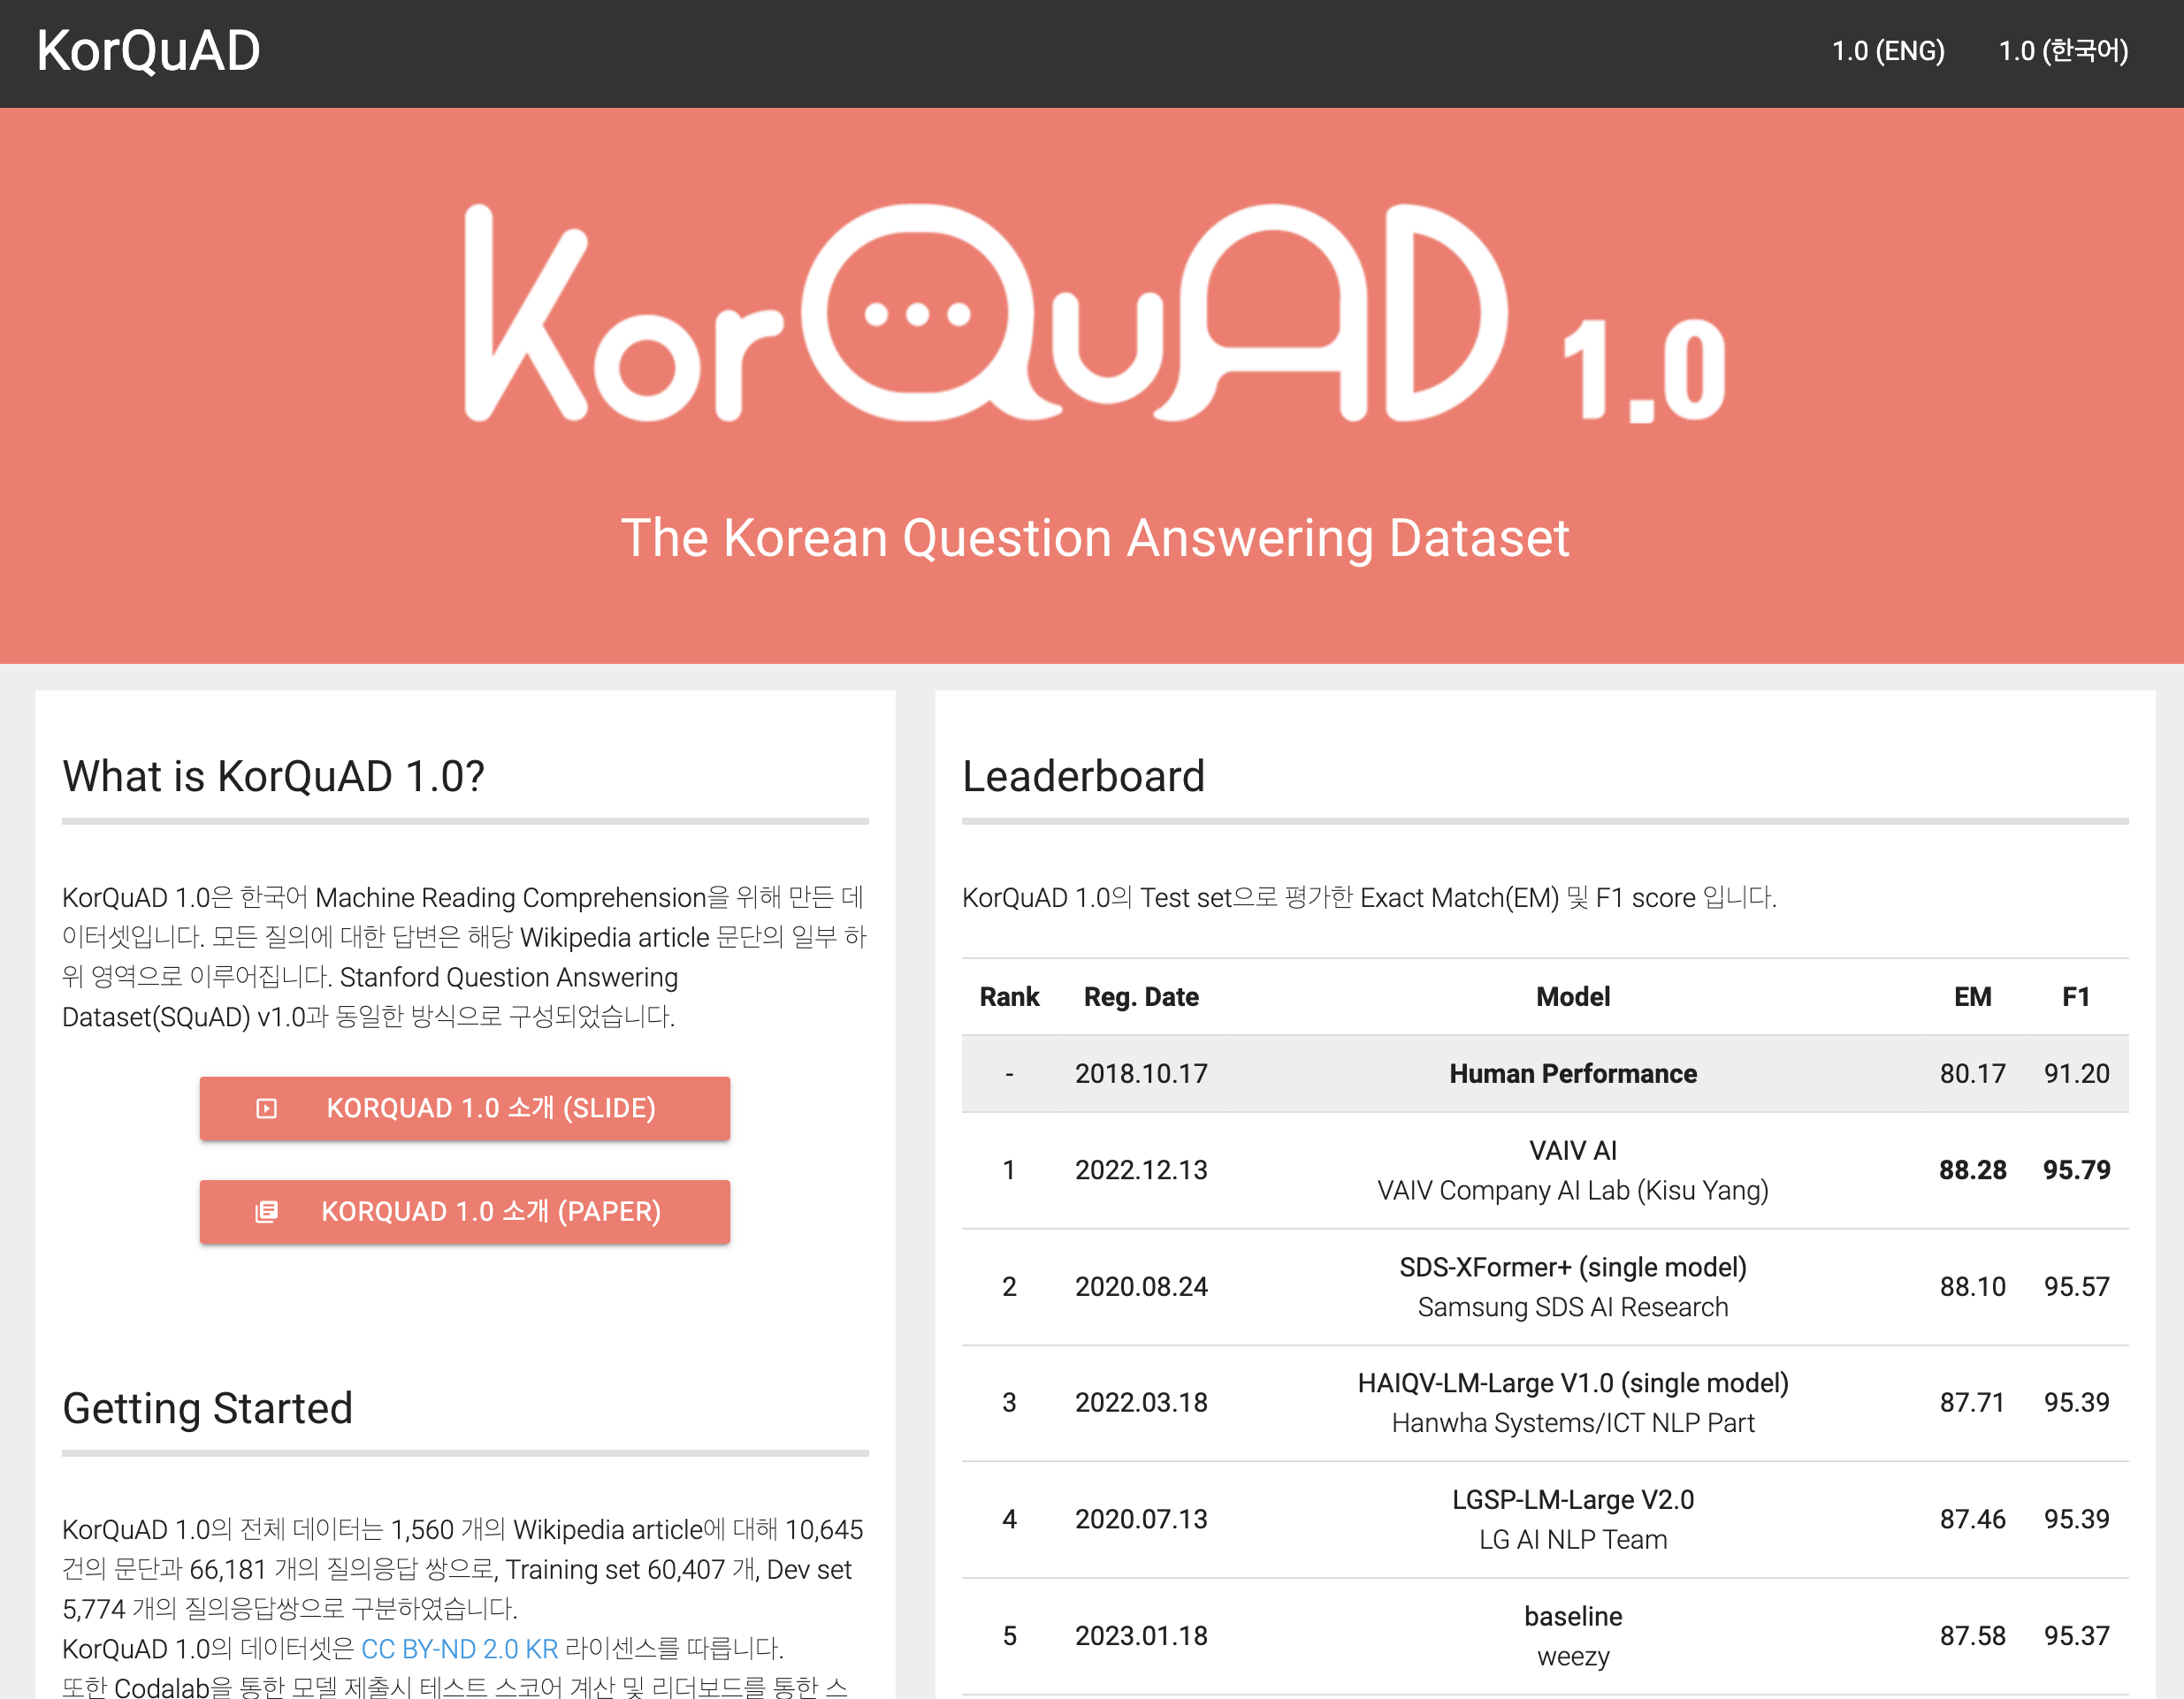

### 1.1. 데이터셋 특징

KorQuAD 1.0의 전체 데이터는 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍에서 수집되었으며,

학습 데이터셋은 60,407 개, Dev set 5,774 개의 질의응답쌍으로 분리됩니다.

KorQuAD 1.0의 데이터셋은 CC BY-ND 2.0 KR 라이센스를 따릅니다.

KorQuAD 데이터셋은 원본 링크에서 직접 다운로드 받을 수 있으나,

오늘 실습에서는 Huggingface의 dataset hub를 이용하여 데이터셋을 로드합니다.

*   KorQuAD 원본 링크 : https://korquad.github.io/KorQuad%201.0/
*   Huggingface datasets : https://huggingface.co/datasets/squad_kor_v1

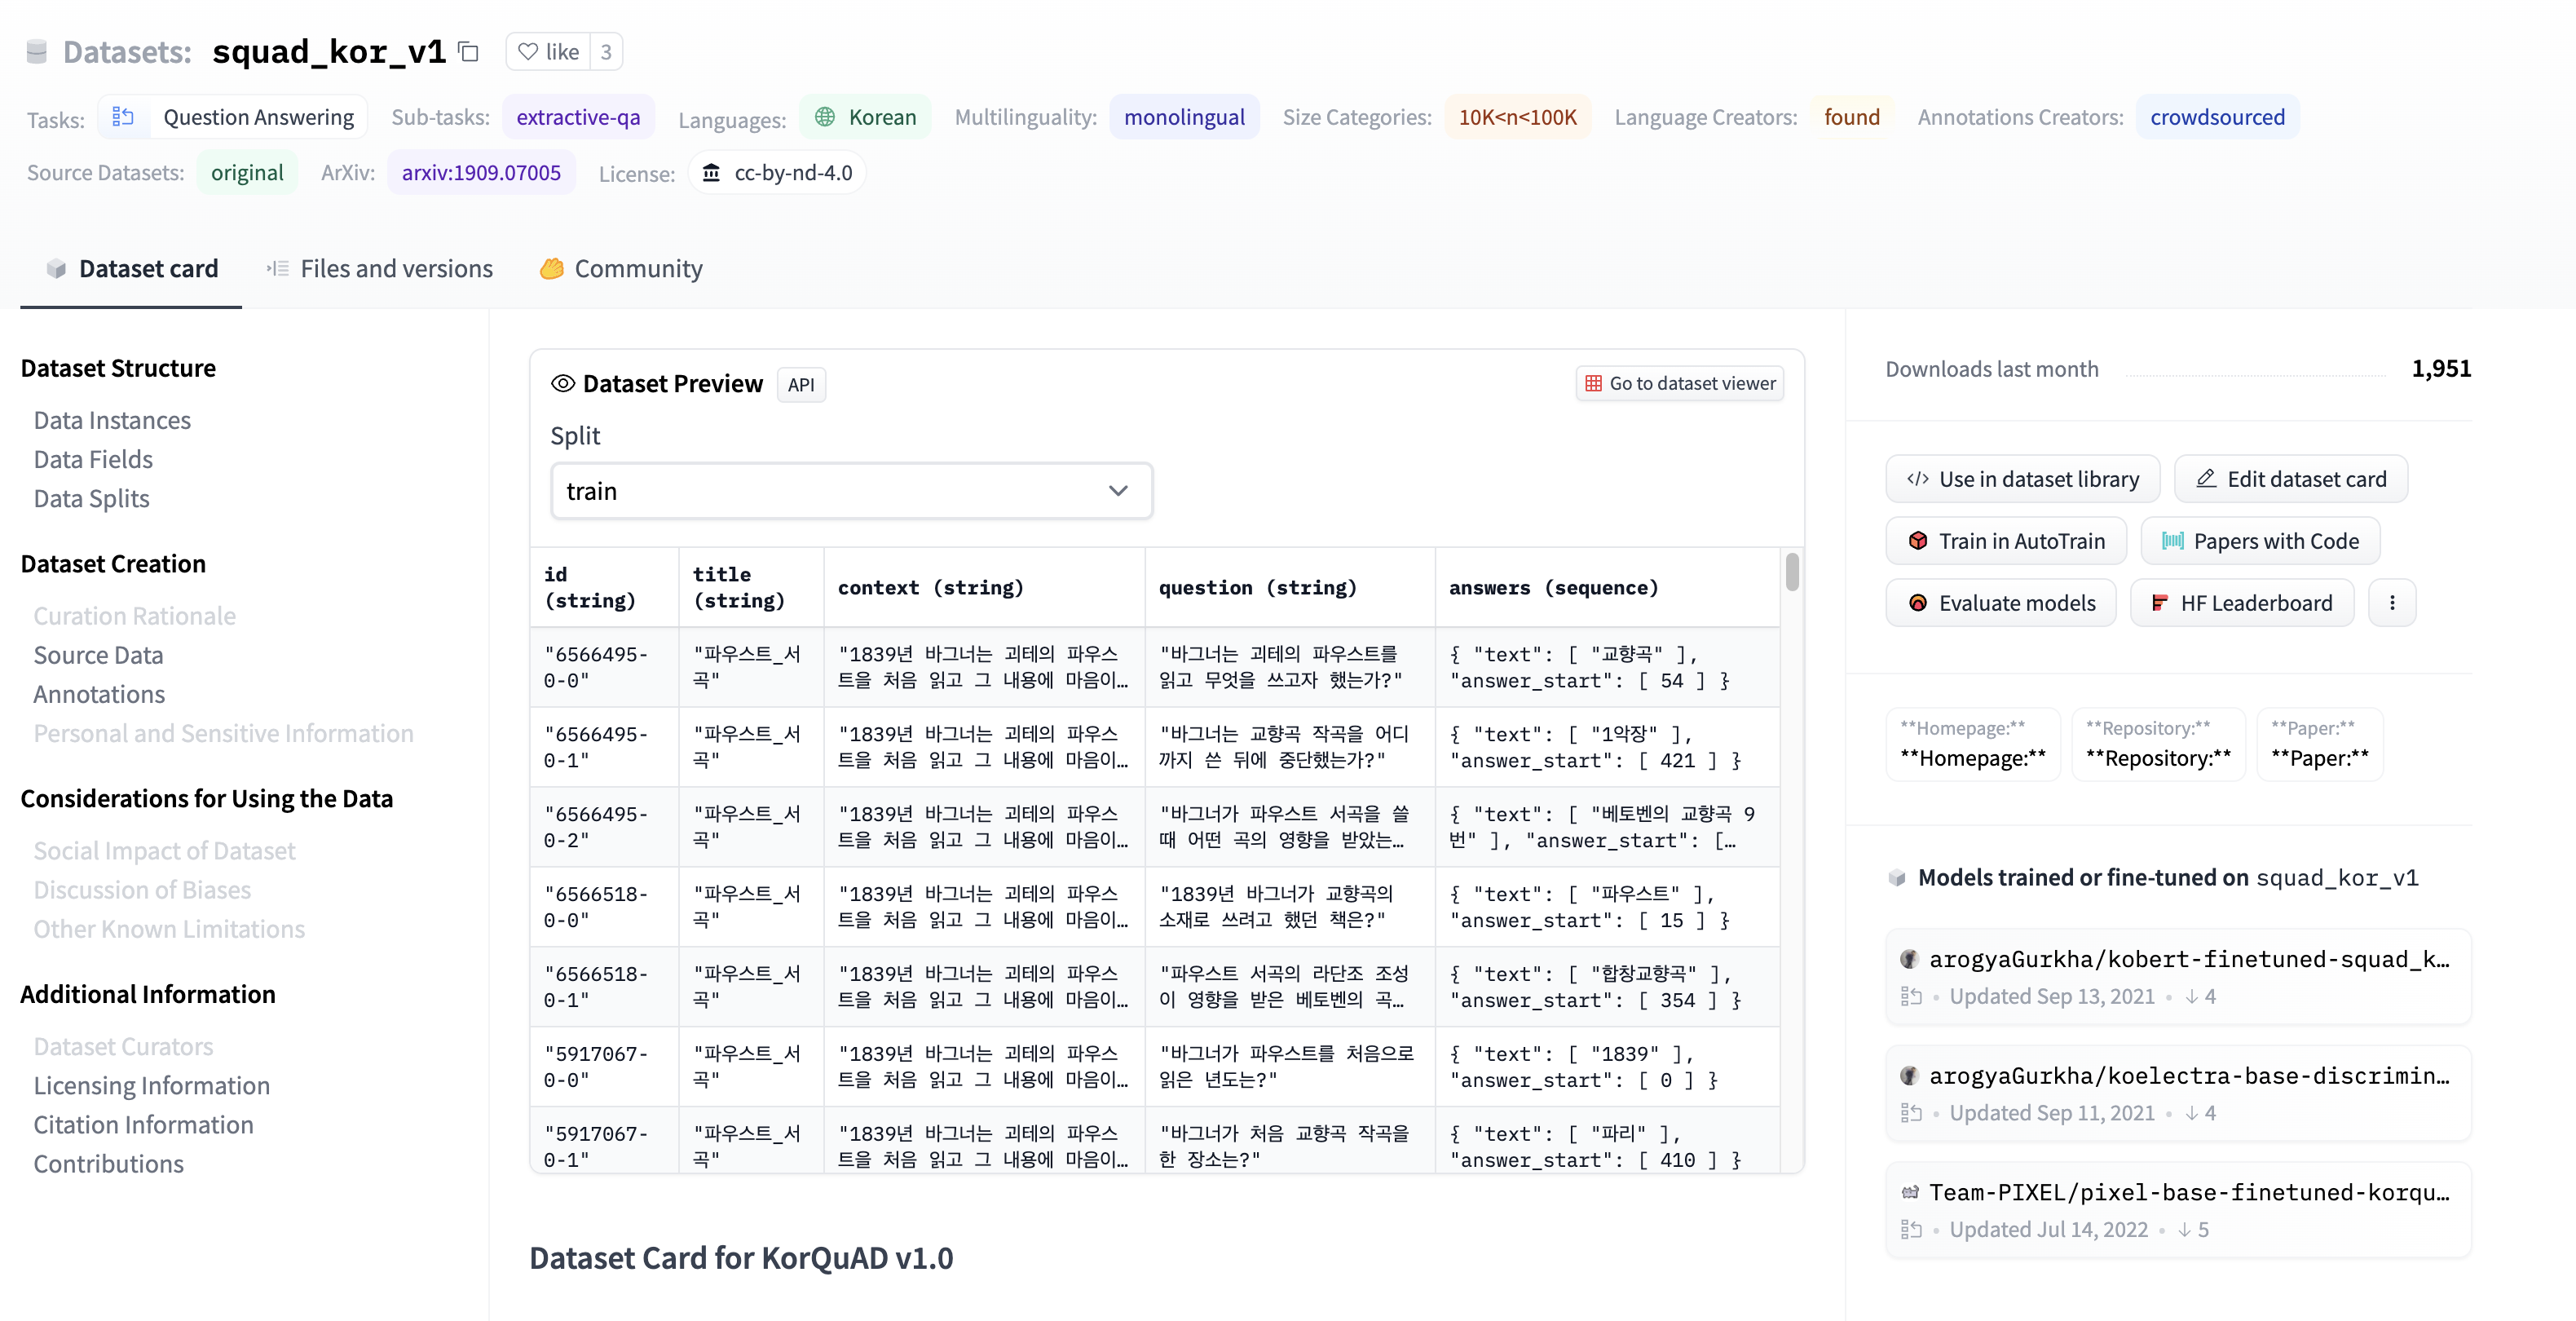

In [2]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("squad_kor_v1")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})

In [6]:
dataset["train"][10]

{'answers': {'answer_start': [345], 'text': ['20루이의 금']},
 'context': '한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게 보내고 브라이트코프흐 & 헤르텔 출판사에는 20루이의 금을 받고 팔았다. 또한 그의 작품을 “하나하나의 음표가 시인의 피로 쓰여졌다”며 극찬했던 한스 폰 뷜로가 그것을 피아노 독주용으로 편곡했는데, 리스트는 그것을 약간 변형되었을 뿐이라고 지적했다. 이 서곡의 총보 첫머리에는 파우스트 1부의 내용 중 한 구절을 인용하고 있다.',
 'id': '6566495-1-2',
 'question': '바그너는 다시 개정된 총보를 얼마를 받고 팔았는가?',
 'title': '파우스트_서곡'}

In [7]:
dataset["train"][60000]

{'answers': {'answer_start': [10], 'text': ['삼지연관현악단']},
 'context': '19일에는 현송월 삼지연관현악단장 등 6명의 사전점검단이 다음 날 방남한다고 밝혔다. 하지만 그날 밤 22시 경에 리선권 조국평화통일위원회 위원장이 조명균 통일부 장관 앞으로 사전점검단의 파견을 중지한다고 일방적으로 통보했다. 중지 이유에 대해서는 언급하지 않았는데 다음 날 이를 번복하여 그 다음 날에 방남을 추진하겠다고 밝혀왔으며 21일 현송월 단장이 이끄는 사전점검단이 경의선 육로를 통해 한국 땅을 밟았다. 이들은 KTX를 이용해서 첫째 날에는 강릉에서 황영조체육관과 강릉아트센터를, 둘째 날에는 서울에서 잠실학생체육관·장충체육관과 국립중앙극장을 둘러보고 그 날 북한으로 돌아갔다. 23일에는 한국도 금강산과 마식령 스키장을 점검하기 위해 이주태 통일부 교류협력국장을 단장으로 하는 사전점검단이 2박 3일의 일정으로 23개월만에 방북했다. 점검단은 스키장의 시설과 이동 경로 및 도로 상태를 점검했다. 원산 갈마공항과 스키장은 시설과 관리상태가 양호하여 한국 선수단의 이동은 항공편을 이용할 전망이지만 금강산호텔이나 이산가족면회소 등은 공연행사장으로 사용하기에 부적합하여 추가 검토가 필요하다고 밝혔다. 전반적으로 통일부는 "선발대는 북측이 준비가 잘되고 있다는 느낌을 받았"다고 전했다. 이때, 동행한 NBC는 스키장을 비롯한 북한의 내부 모습이나 북한 주민들과의 인터뷰를 보도했는데 긍정적으로 묘사한 것이 미국에서 논란이 되었다. 백악관은 "지구 상에서 가장 전체주의적인 국가를 흥겨운 겨울 휴양지로 보이도록 하는 게 그리 쉬운 일이 아닌데, 어쨌든 NBC가 그 일을 했다"며 냉소적인 반응을 보이는 등 NBC가 북한의 선전술에 이용당했다는 비판이 나오는 것이다. 선발대가 돌아오기 하루 전인 25일에는 북한 여자 아이스하키 선수단 15명과 올림픽 시설을 둘러보기 위한 윤용복 체육성 부국장을 단장으로 하는 선발대 8명이 다시 방남했다. 선발대는 인제

이 때, 데이터셋의 answer_start field는 context에서 answer가 시작하는 부분을 가리킵니다.

In [8]:
example = dataset["train"][10]

In [10]:
context = example['context']
answer_text = example['answers']['text'][0]
answer_text

'20루이의 금'

In [11]:
answer_start = example['answers']['answer_start'][0]
answer_end = answer_start + len(answer_text)
print('Answer from context = ', context[answer_start:answer_end])

Answer from context =  20루이의 금


## 2. 문장 토큰화 작업

문장과 질문을 모델에 입력으로 넣기 위해서는, 문장과 질문을 모두 토큰화하여 수치화해야합니다.

간단한 실습을 위하여, transformers의 AutoTokenizer를 활용하여,

multilingual-BERT의 tokenizer를 불러오겠습니다.

In [12]:
from transformers import AutoTokenizer

In [13]:
model_checkpoint = "bert-base-multilingual-cased"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [15]:
train_sample = dataset["train"][0]['question']
train_sample

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'

In [16]:
tokenizer.tokenize(train_sample)

['바',
 '##그',
 '##너',
 '##는',
 '괴',
 '##테',
 '##의',
 '파',
 '##우스',
 '##트를',
 '읽',
 '##고',
 '무',
 '##엇',
 '##을',
 '쓰',
 '##고',
 '##자',
 '했',
 '##는',
 '##가',
 '?']

위 train_sample 예시에 대한 토크나이징 결과는 다음과 같습니다.

In [17]:
tokenizer(train_sample)

{'input_ids': [101, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 101825, 9642, 11664, 9294, 119137, 10622, 9511, 11664, 13764, 9965, 11018, 11287, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

이후, 모델 추론 결과 분석 과정에서는 토큰화된 단어 인덱스를 다시 텍스트로 변환할 수 있어야 합니다.

In [18]:
' '.join(tokenizer.tokenize(train_sample)).replace(' ##', '')

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가 ?'

tokenizer class의 decode 함수를 사용하여 단어 인덱스를 다시 텍스트로 변환할 수도 있습니다.

In [19]:
tokenizer.decode(tokenizer(train_sample)['input_ids'])

'[CLS] 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? [SEP]'

## 3. 데이터셋 전처리

기계 번역 작업의 입력에는 문맥(context)과 질문(question)이 모두 들어가야하므로,

문맥과 질문의 길이를 모두 고려하여 최대 길이를 설정해야 합니다.

In [20]:
max_seq_length = 384

만약, 문맥(context)의 길이가 너무 긴 경우에는, 해당 문맥을 복수의 paragraph로 분리해줘야하며,

이 때 paragraph 간 의미를 연결짓기 위해, 분리된 paragraph끼리 오버랩되는 시퀀스 길이를 설정해줘야 합니다.

In [21]:
doc_stride = 128

샘플 전처리 시행

In [22]:
samples = dataset['train'][:5]

tokenizer 클래스의 truncation의 option을 "only_second"로 줄 경우에, (질문, 문맥) 입력의 두 번째에 위치할 문맥에서 truncation을 진행합니다.

질문보다 문맥을 truncation하는 것이 성능에 영향을 덜 미칠 것이라는 가정하에 시도하는 전략

이 때, return_overflowing_tokens option을 True로 설정하면, overflowing token sequece를 반환받을 수 있으며,

return_offsets_mapping option을 True로 설정하면, 각 토큰의 (char_start, char_end) 위치를 반환합니다.

In [23]:
tokenized_examples = tokenizer(
    samples["question"],
    samples["context"],
    truncation="only_second",
    max_length=max_seq_length,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
)

In [24]:
tokenized_examples.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [25]:
len(tokenized_examples['input_ids'])

10

In [ ]:
tokenized_examples['input_ids'][0]

In [ ]:
tokenized_examples['offset_mapping'][0]

In [28]:
tokenized_examples['overflow_to_sample_mapping']

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

이제 텍스트가 주어졌을 때, 해당 데이터셋을 토크나이징하는 함수를 선언합니다.

중요한 것은, 문맥(context)의 길이가 앞서 설정한 max_seq_length를 넘으면, 미리 설정한 stride만큼 슬라이딩하여 하나의 문맥을 여러 개의 paragraph로 분리해야 합니다.

즉, 하나의 데이터에서 문맥의 일부가 겹치는 여러 sequence(feature)가 생길 수 있습니다.

In [29]:
def transform_features(samples):
    tokenized_samples = tokenizer(
        samples["question"],
        samples["context"],
        truncation="only_second",
        max_length=max_seq_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    # 데이터 하나가 여러 sequence에 대응하는 경우를 위해 매핑이 필요
    overflow_to_sample_mapping = tokenized_samples.pop("overflow_to_sample_mapping")
    
    # 토큰의 원본 문맥(context) 내 위치를 알 수 있음
    offset_mapping = tokenized_samples.pop("offset_mapping")

    # 정답지를 만들기 위한 리스트
    tokenized_samples["start_positions"] = []
    tokenized_samples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_samples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        
        # 해당 sample에 해당하는 sequence를 검색
        sequence_ids = tokenized_samples.sequence_ids(i)
        
        # sequence가 속하는 데이터를 찾아야 함
        sample_index = overflow_to_sample_mapping[i]
        
        answers = samples["answers"][sample_index]
        
        # 문맥(context) 내 answer의 시작, 마지막 위치
        start_offset = answers["answer_start"][0]
        end_offset = start_offset + len(answers["text"][0])

        # 문맥(context)에서 현재 span의 시작 토큰 인덱스
        start_index = 0
        while sequence_ids[start_index] != 1:
            start_index += 1
        
        # 문맥(context)에서 현재 span 마지막 토큰 인덱스
        end_index = len(input_ids) - 1
        while sequence_ids[end_index] != 1:
            end_index -= 1

        # answer가 현재 span을 벗어났는지 체크
        if not (offsets[start_index][0] <= start_offset and offsets[end_index][1] >= end_offset):
          tokenized_samples["start_positions"].append(cls_index)
          tokenized_samples["end_positions"].append(cls_index)
        else:
          # start_index와 end_index를 answer의 시작점과 끝점으로 옮김
          
          while start_index < len(offsets) and offsets[start_index][0] <= start_offset:
              start_index += 1
          tokenized_samples["start_positions"].append(start_index - 1)
          
          while offsets[end_index][1] >= end_offset:
              end_index -= 1
          tokenized_samples["end_positions"].append(end_index + 1)

    return tokenized_samples

In [30]:
transformed_dataset = transform_features(dataset['train'][:2])

In [31]:
transformed_dataset

for input_ids, token_type_ids, attention_mask, start_position, end_position in zip(
    transformed_dataset["input_ids"],
    transformed_dataset["token_type_ids"],
    transformed_dataset["attention_mask"],
    transformed_dataset["start_positions"],
    transformed_dataset["end_positions"],
):
  print(f"input_ids = {input_ids}")
  print(f"token_type_ids = {token_type_ids}")
  print(f"attention_mask = {attention_mask}")
  print(f"start_position = {start_position}")
  print(f"end_position = {end_position}")

input_ids = [101, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 101825, 9642, 11664, 9294, 119137, 10622, 9511, 11664, 13764, 9965, 11018, 11287, 136, 102, 16221, 10954, 9318, 78136, 70162, 11018, 8905, 119351, 10459, 9901, 89108, 15184, 10622, 62849, 9642, 11664, 8924, 8996, 24974, 10530, 9246, 32158, 10739, 8973, 26737, 35756, 9448, 36210, 11261, 9960, 12424, 90387, 8907, 79544, 55670, 10622, 9511, 26737, 11018, 9153, 10622, 8854, 40410, 119, 9638, 9485, 12310, 9318, 78136, 70162, 11018, 16347, 27056, 9387, 9088, 119267, 11467, 9407, 16617, 15891, 54918, 9056, 100, 9414, 65649, 10739, 17342, 9686, 58931, 11882, 9489, 89292, 10530, 8843, 118813, 51491, 9272, 97146, 12605, 26444, 119394, 100929, 11513, 9248, 49742, 9901, 89108, 15184, 10459, 9491, 31720, 10530, 8896, 105197, 12490, 11664, 16139, 119, 19789, 9901, 46766, 12424, 9519, 52015, 77884, 20308, 10459, 9706, 119455, 11261, 9901, 12692, 74293, 14279, 8900, 30842, 119110, 24989, 10739, 9568, 16323, 12178, 9344, 264

## 4. 기계 독해 작업의 평가 지표

KorQuAD 1.0의 데이터셋을 Huggingface hub를 통해 불러오면, 다음과 같이 해당 데이터셋의 메트릭을 사용할 수 있음

KorQuAD 1.0의 벤치마크 메트릭은 Exact Match(EM)과 F1 score

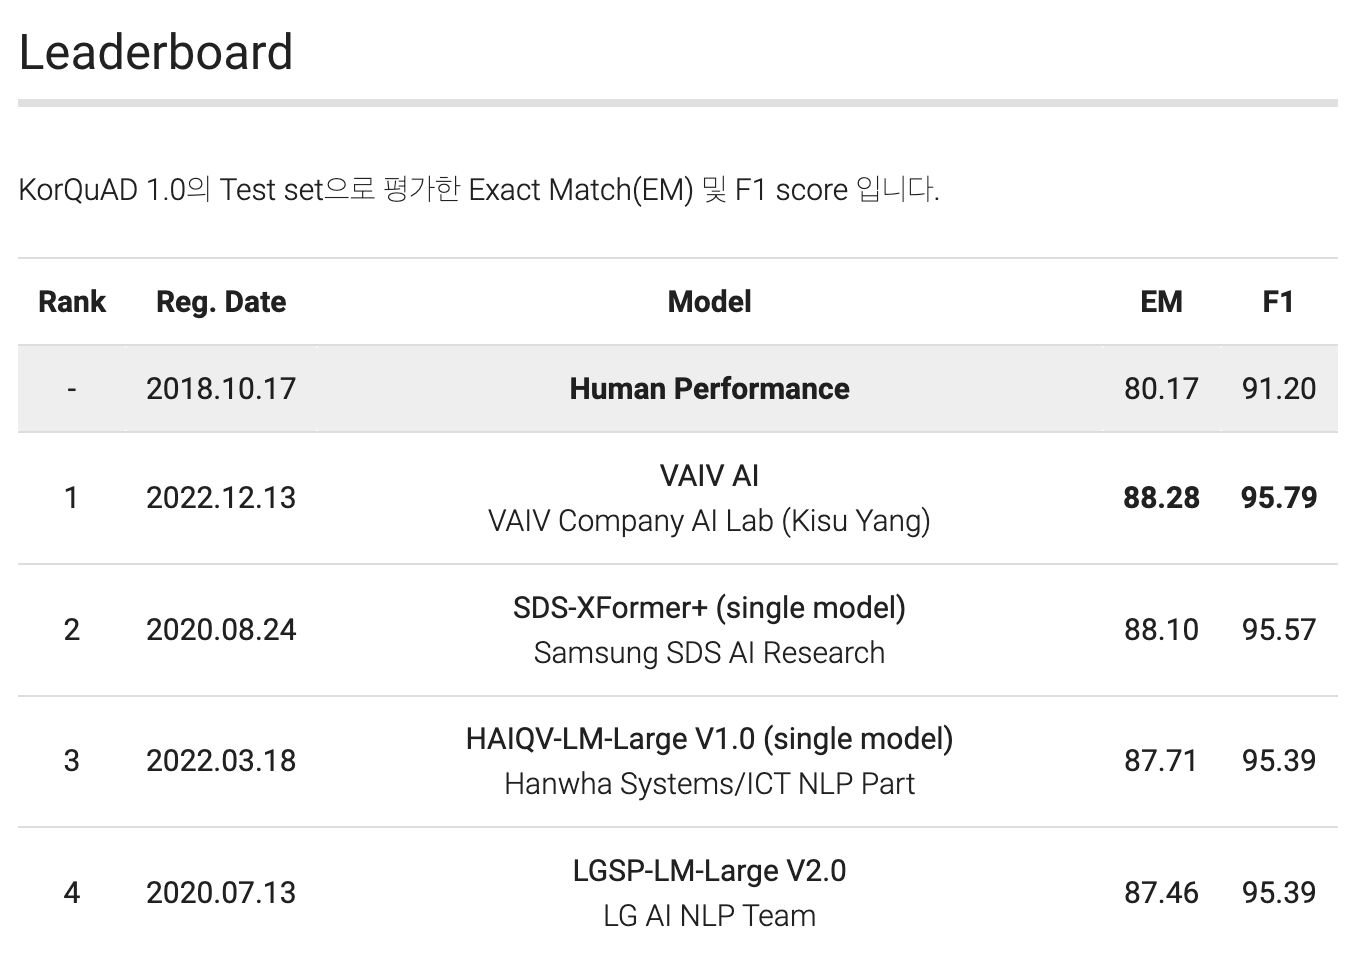

In [32]:
from datasets import load_metric

In [33]:
metric = load_metric('squad')

In [34]:
metric

Metric(name: "squad", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD scores (F1 and EM).
Args:
    predictions: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair as given in the references (see below)
        - 'prediction_text': the text of the answer
    references: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair (see above),
        - 'answers': a Dict in the SQuAD dataset format
            {
                'text': list of possible texts for the answer, as a list of strings
                'answer_start': list of start positions for the answer, as a list of ints
   

In [35]:
evaluation_sample = dataset['train'][0]
evaluation_sample

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

In [36]:
evaluation_sample2 = dataset['train'][1]
evaluation_sample2

{'answers': {'answer_start': [421], 'text': ['1악장']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-1',
 'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 'title': '파우스트_서곡'}

In [37]:
metric.compute(
  references=[
    {"id": evaluation_sample["id"], "answers": evaluation_sample["answers"]}
  ],
  predictions=[
    {"id": evaluation_sample["id"], "prediction_text": "교향곡"}
  ]
)

{'exact_match': 100.0, 'f1': 100.0}

In [38]:
metric.compute(
  references=[
    {"id": evaluation_sample["id"], "answers": evaluation_sample["answers"]}
  ],
  predictions=[
    {"id": evaluation_sample["id"], "prediction_text": "교향곡 9번"}
  ]
)

{'exact_match': 0.0, 'f1': 66.66666666666666}

다음과 같이 여러 개의 샘플을 한 번에 측정 가능

In [40]:
metric.compute(
  references=[
    {"id": pair["id"], "answers": pair["answers"]} for pair in [evaluation_sample, evaluation_sample2]
  ],
  predictions=[
    {"id": evaluation_sample["id"], "prediction_text": "교향곡 9번"}, {"id": evaluation_sample2["id"], "prediction_text": "1악장"}
  ]
)

{'exact_match': 50.0, 'f1': 83.33333333333333}